In [40]:
import os
import copy
import time
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
import time
import argparse
import random
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision

from utils.options import *
from utils.function import *
from utils.evaluation import *
from dataprocess.data_utils import *
from dataprocess.imbalance_cifar import *
from models.resnet import *
from models.vgg import *
from PIL import Image
from glob import glob
from torch.utils.data import SubsetRandomSampler, SequentialSampler
from torch.autograd import Variable
from matplotlib.pyplot import subplots
from torchvision.utils import save_image
import torchvision.models as models

In [41]:
random_seed = 42
gpu = 0
test_bs = 20

save_paths = [
    r"vgg_decoder",
    r"mixsl3-vgg_decoder",
    r"mixsl4-vgg_decoder",
    r"mixsl5-vgg_decoder",
    r"mixsl6-vgg_decoder",
    r"mixsl7-vgg_decoder",
    r"mixsl8-vgg_decoder",
    r"mixsl9-vgg_decoder",
    r"mixsl10-vgg_decoder"]


data_paths = [
    [r'../input/cifar100', r'../output/cifar100'],
    [r'../mixsl3input/cifar100', r'../mixsl3output/cifar100'],
    [r'../mixsl4input/cifar100', r'../mixsl4output/cifar100'],
    [r'../mixsl5input/cifar100', r'../mixsl5output/cifar100'],
    [r'../mixsl6input/cifar100', r'../mixsl6output/cifar100'],
    [r'../mixsl7input/cifar100', r'../mixsl7output/cifar100'],
    [r'../mixsl8input/cifar100', r'../mixsl8output/cifar100'],
    [r'../mixsl9input/cifar100', r'../mixsl9output/cifar100'],
    [r'../mixsl10input/cifar100', r'../mixsl10output/cifar100']
]

In [42]:
class Attacker(nn.Module):
    def __init__(self):
        super(Attacker, self).__init__()
        model = []
        model += [nn.ConvTranspose2d(128, 128,  kernel_size=3, stride=2, padding=1, output_padding=1),
                   nn.BatchNorm2d(128),
                  nn.ReLU(inplace=True)]
        
        model += [nn.ConvTranspose2d(128, 64,  kernel_size=3, stride=1, padding=1, output_padding=0),
                   nn.BatchNorm2d(64),
                  nn.ReLU(inplace=True)]
        
        model += [nn.ConvTranspose2d(64, 64,  kernel_size=3, stride=2,padding=1,output_padding=1),
                   nn.BatchNorm2d(64),
                  nn.ReLU(inplace=True)]
        
        model += [nn.ConvTranspose2d(64, 3,  kernel_size=3, stride=1, padding=1, output_padding=0),
                   nn.BatchNorm2d(3),
                  nn.ReLU(inplace=True)]

        self.m = nn.Sequential(*model)
    
    def forward(self, x):
        for l in self.m:
            #print(x.size())
            x = l(x)
            #print(x.shape)
        return x

In [43]:
class ImageTensorFolder(Dataset):

    def __init__(self, img_path, tensor_path, img_fmt="npy", tns_fmt="npy", transform=None):
        self.img_fmt = img_fmt
        self.tns_fmt = tns_fmt
        self.img_paths = self.get_all_files(img_path, file_format=img_fmt)
        self.tensor_paths = self.get_all_files(tensor_path, file_format=tns_fmt)

        self.transform = transform
        self.to_tensor = transforms.ToTensor()
        self.to_pil = transforms.ToPILImage()

    def get_all_files(self, path, file_format="png"):
        filepaths = path + "/*.{}".format(file_format)
        files = glob(filepaths)
        #print(files[0:10])
        return files[0:20]

    def load_img(self, filepath, file_format="png"):
        img = np.load(filepath)
        img = torch.from_numpy(img)
        return img

    def load_tensor(self, filepath, file_format="png"):
        tensor = np.load(filepath)
        tensor = torch.from_numpy(tensor)
        return tensor

    def __getitem__(self, index):
        img = self.load_img(self.img_paths[index], file_format=self.img_fmt)
        intermed_rep = self.load_tensor(self.tensor_paths[index], file_format=self.tns_fmt)
        return img, intermed_rep

    def __len__(self):
        return len(self.img_paths)
    
    
def apply_transform(batch_size, image_data_dir, tensor_data_dir):
    
    trainTransform = transforms.Compose([transforms.ToTensor(),])
    dataset = ImageTensorFolder(img_path=image_data_dir, tensor_path=tensor_data_dir, img_fmt="npy", tns_fmt="npy", transform=trainTransform)
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    np.random.seed(random_seed)
    test_indices = indices[0:]
    test_sampler = SequentialSampler(test_indices)
    testloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=batch_size,
                                             shuffle=False, num_workers=4,
                                             sampler=test_sampler)


    return testloader

In [44]:
def denormalize(img, dataset="cifar10"):
    """
    data is normalized with mu and sigma, this function puts it back
    """
    if dataset == "cifar10":
        c_std = [0.2023, 0.1994, 0.2010]
        c_mean = [0.4914, 0.4822, 0.4465]
    elif dataset == "imagenet":
        c_std = [0.229, 0.224, 0.225]
        c_mean = [0.485, 0.456, 0.406]
    for i in [0, 1, 2]:
        img[i] = img[i] * c_std[i] + c_mean[i]
    return img

Model 0 load checkpoint.....


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model 1 load checkpoint.....


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model 2 load checkpoint.....


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model 3 load checkpoint.....


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model 4 load checkpoint.....


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model 5 load checkpoint.....


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model 6 load checkpoint.....


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model 7 load checkpoint.....


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model 8 load checkpoint.....


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


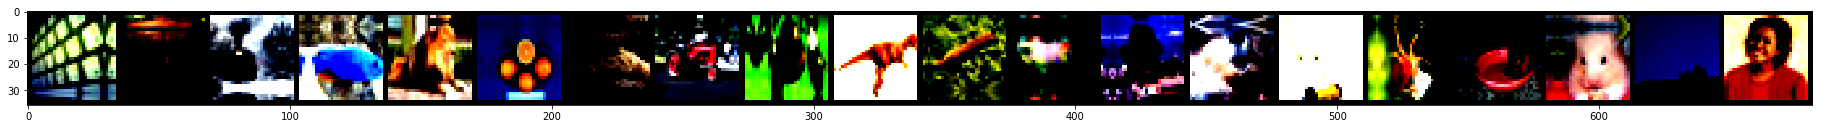

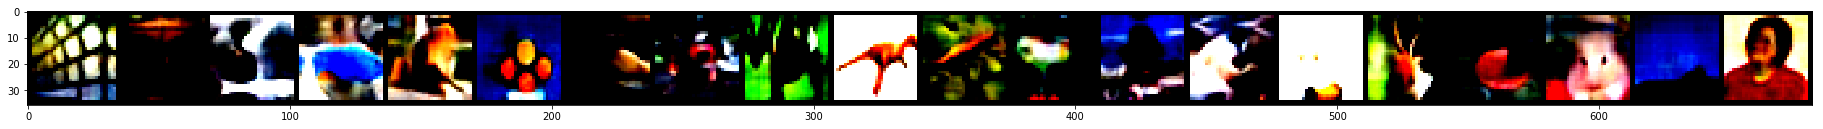

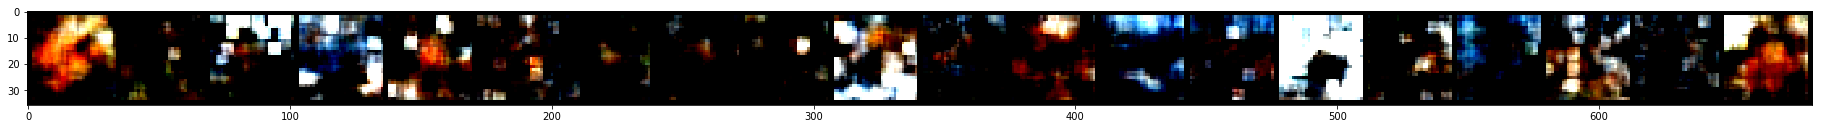

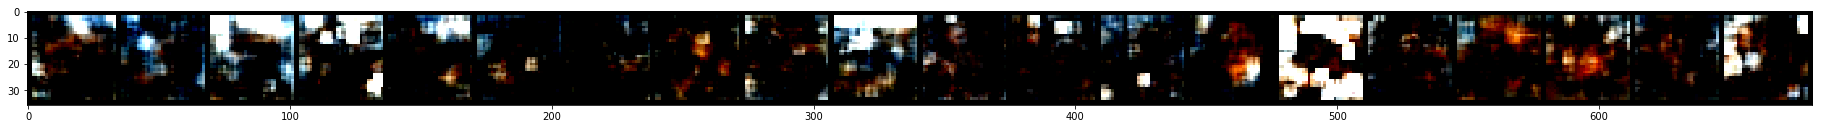

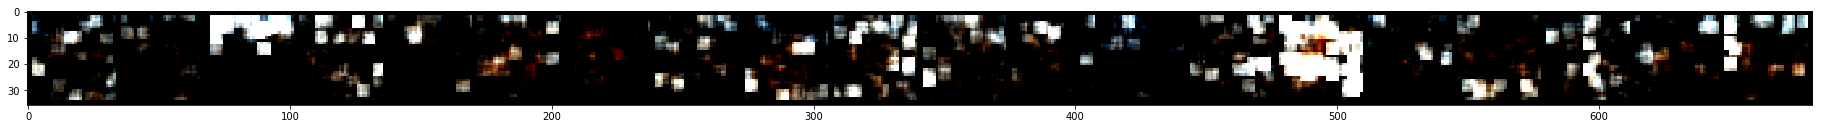

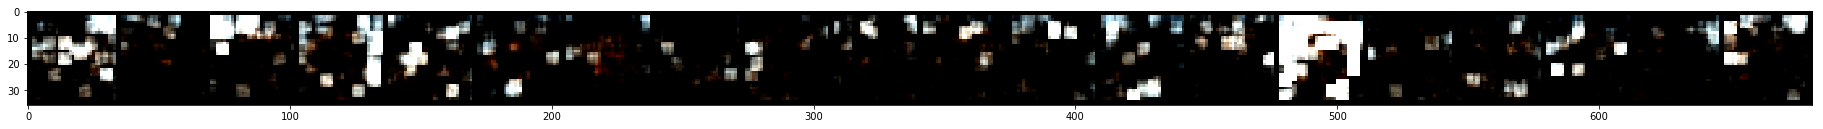

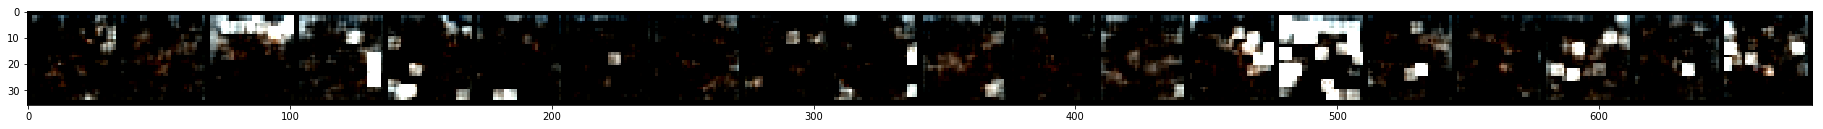

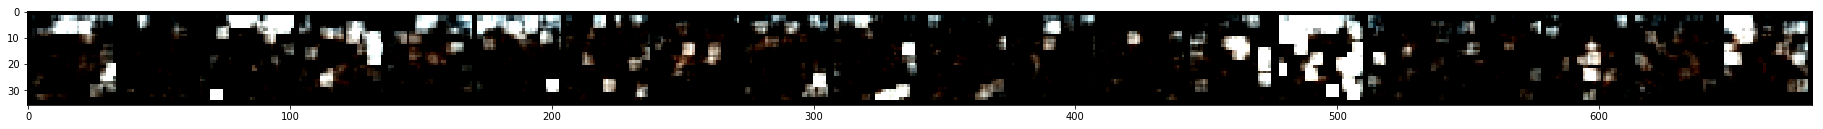

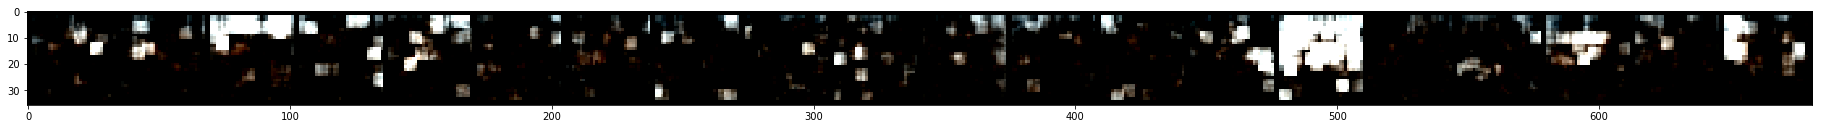

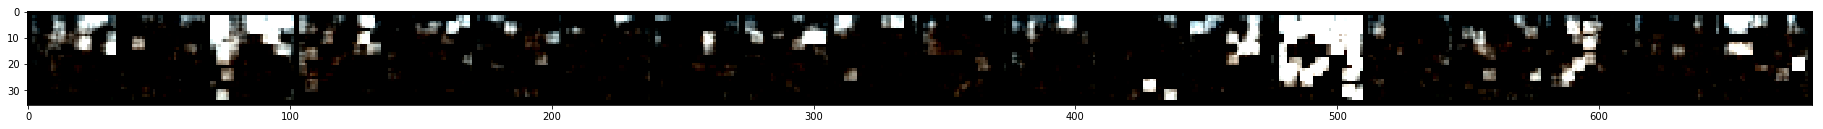

In [46]:
setup_seed(42, True)

for i in range(len(save_paths)):
    decoder = Attacker()
    print(f"Model {i} load checkpoint.....")
    #print(f"save_paths: {save_paths[i]}.......")
    ckpt = torch.load('../checkpoints/' + save_paths[i] + '_ckpt')
    decoder.load_state_dict(ckpt)
    decoder.cuda(gpu)
    #print("load dataset.......")
    testloader = apply_transform(test_bs, data_paths[i][0], data_paths[i][1])
    
    for num, data in enumerate(testloader, 1):
        img, ir = data
        img, ir = Variable(img).to(gpu), Variable(ir).to(gpu)
        output = decoder(ir)
        
        if i == 0:
            out0grid = torchvision.utils.make_grid(img, nrow=20)
            fig, ax = subplots(figsize=(32, 32))
            ax.imshow(out0grid.detach().permute(1, 2, 0).cpu())

        out0grid1 = torchvision.utils.make_grid(output, nrow=20)
        fig1, ax1 = subplots(figsize=(32, 32))
        ax1.imshow(out0grid1.detach().permute(1, 2, 0).cpu())